In [9]:
import numpy as np
import os
from scipy.stats import uniform, beta
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from copy import deepcopy
from itertools import product
from sklearn.metrics import mean_absolute_error
import networkx as nx

from collections import Counter
from itertools import product
import pickle


from InfluenceDiffusion.Graph import Graph
from InfluenceDiffusion.influence_models import LTM, ICM
from InfluenceDiffusion.estimation_models.EMEstimation import ICWeightEstimatorEM, LTWeightEstimatorEM
from InfluenceDiffusion.weight_samplers import make_random_weights_with_indeg_constraint, \
                                               make_random_weights_with_fixed_indeg, \
                                               make_weighted_cascade_weights

os.chdir("/Users/amkagan/Desktop/gltm_experiments")

from benchmark_estimators import propagated_trace_number_weight_estimator, \
                                 propagated_trace_proportion_weight_estimator

from utils.trace_utils import make_report_traces, trace_train_test_split
from utils.model_evaluation_utils import plot_estimator_output_vs_variable
from utils.utils import plot_distribution, make_name_from_dict, RMAE


In [10]:
from typing import List, Dict


def sample_traces_from_graphs(graphs: Dict[tuple, Graph], 
                  n_traces: int, 
                  n_trace_sets_per_graph: int,
                  max_seed_size: int,         
                  report_traces=True):
    
    traces_over_graphs = {}
    seed_size_range = range(1, max_seed_size + 1) 

    for g_key, g in graphs.items():
        traces_over_graphs[g_key] = []
        for _ in range(n_trace_sets_per_graph):
            ltm = LTM(g)
            traces = ltm.sample_traces(n_traces=n_traces, seed_size_range=seed_size_range)
            if report_traces:
                make_report_traces(traces)
            traces_over_graphs[g_key].append(traces)
    return traces_over_graphs


def normalize_graph_weights_to_fixed_indeg(weights, g: Graph, indeg=1.):
    assert len(weights) == g.count_edges()
    weights = np.array(weights, dtype=float)
    for v in g.get_sinks():
        mask = g.get_parents_mask(v)
        weights[mask] /= weights[mask].sum() 
    return weights * indeg

## Define graph range

In [11]:
p = 0.1

n_nodes = 100
trace_set_sizes=[4000, 2000, 1000, 500, 250]
# nodes_range = [10, 20]
# trace_set_sizes=[100, 50]

model_names = ["LT-EM", "IC-EM", "PTP", "WC"]
random_state = 1
error_metric = RMAE
fixed_indeg = False
indeg_ub = 1

max_seed_size = 5
n_jobs = cpu_count()

n_trace_sets_per_graph = 5

In [12]:
max_n_traces = max(trace_set_sizes)

save_dict = {"n_nodes": n_nodes, 
             "max_traces": max_n_traces,
             "max_seed_size": max_seed_size,  
             "p": p, 
             "random_state": random_state,
             "n_trace_sets_per_graph": n_trace_sets_per_graph,
             "fixed_indeg": fixed_indeg,
             "indeg_ub": indeg_ub}

save_name = make_name_from_dict(save_dict)

## Weight & time estimation

In [13]:
np.random.seed(random_state)

print("Making graphs...")

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=random_state, directed=True)
g = Graph(g.edges)

simplex_weights = make_random_weights_with_fixed_indeg(g, indeg_ub=indeg_ub)
inside_simplex_weights = make_random_weights_with_indeg_constraint(g, indeg_ub=indeg_ub)
graphs = {"simplex": deepcopy(g).set_weights(simplex_weights), 
          "inside_simplex": deepcopy(g).set_weights(inside_simplex_weights)}

print("Sampling traces...")
traces_over_graphs = sample_traces_from_graphs(graphs=graphs,
                                               n_traces=max_n_traces,
                                               n_trace_sets_per_graph=n_trace_sets_per_graph, 
                                               max_seed_size=max_seed_size,
                                               report_traces=False)


Making graphs...
Sampling traces...


In [ ]:
estimation_dict = {g_key: {n_traces: {model_name: {"weights": [], "errors": []} 
                              for model_name in model_names} for n_traces in trace_set_sizes}
                   for g_key in graphs}

print("Estimating weights")
for model_name in model_names:
    print(f"Model {model_name}")
    for g_key, trace_sets in traces_over_graphs.items():
        g = graphs[g_key]
        for traces in trace_sets:
            n_nodes = g.count_vertices()
            for n_traces in trace_set_sizes:
                tmp_traces = traces[:n_traces]
                if model_name == "WC":
                    weights = make_weighted_cascade_weights(g)
                elif model_name == "PTN":
                    weights = propagated_trace_number_weight_estimator(g, tmp_traces)
                elif model_name == "PTP":
                    weights = propagated_trace_proportion_weight_estimator(g, tmp_traces)
                elif model_name == "UN":
                    weights = np.ones_like(g.weights) / g.get_max_indegree()
                elif model_name == "LT-EM":
                    model = LTWeightEstimatorEM(g, n_jobs=None)
                    model.fit(tmp_traces, max_iter=100, tol=1e-3)
                    weights = model.weights_
                elif model_name == "IC-EM":
                    model = ICWeightEstimatorEM(g, n_jobs=None)
                    model.fit(tmp_traces, max_iter=100, tol=1e-3)
                    weights = normalize_graph_weights_to_fixed_indeg(model.weights_, g, indeg=indeg_ub)
                elif model_name == "GLT":
                    model = GLTWeightEstimator(g, n_jobs=n_jobs)
                    model.fit(tmp_traces)
                    weights = model.weights_
                else:
                    raise NotImplementedError(f"No {model_name} key in weights_dict")
                    
                estimation_dict[g_key][n_traces][model_name]["weights"].append(weights)
                error = error_metric(g.weights, weights)
                estimation_dict[g_key][n_traces][model_name]["errors"].append(error)
with open(f"saved_results/estim_accuracy_{save_name}.pkl", "wb") as f:
    pickle.dump(estimation_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open(f"saved_results/estim_accuracy_{save_name}.pkl", "rb") as f:
    estimation_dict = pickle.load(f)

In [15]:
colors = ["tab:green", "tab:red", "tab:purple", "tab:brown"]

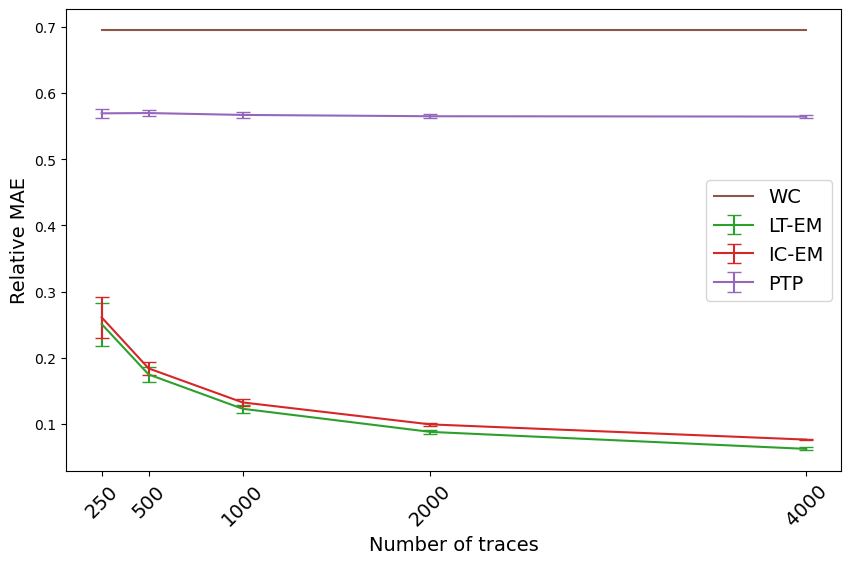

In [19]:
plt.figure(figsize=(10, 6))
plt.yticks(np.linspace(0.1, 0.8, 8))
plot_estimator_output_vs_variable(estimation_dict["simplex"], output_key="errors", 
                                  ylabel="Relative MAE", xlabel="Number of traces", colors=colors)
plt.savefig("figures/on_simplex_errors.png", dpi=150, bbox_inches="tight")


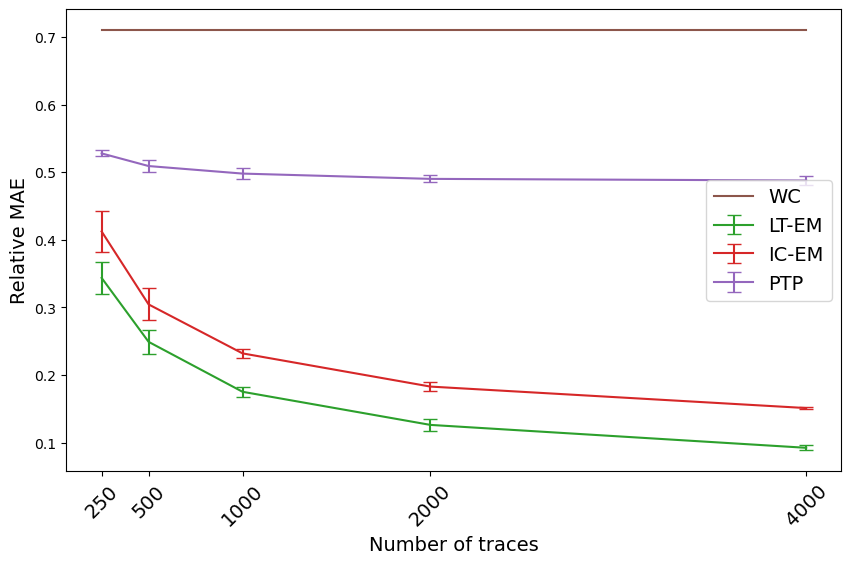

In [20]:
plt.figure(figsize=(10, 6))
plt.yticks(np.linspace(0.1, 0.8, 8))

plot_estimator_output_vs_variable(estimation_dict["inside_simplex"], output_key="errors",
                                  ylabel="Relative MAE", xlabel="Number of traces", colors=colors)
plt.legend(loc="right", fontsize=14)
plt.savefig("figures/inside_simplex_errors.png", dpi=150, bbox_inches="tight")
